# Users Interactions Activities

### Summary and Introduction

Exploring the User to User interaction grphs which contains data extracted from twitter with decoded usernames and no metadata, here we will try to explore the data and discover the hidden patterns in the graph as a cold begin.

#### Goals
1. Explore the data and it's covariences
2. Exploring data distribution and shape
3. Understanding interactions between users and trying to recognize categorize or meaningfull patterns from it
4. Making hypothesis , test it, and build next stages on it

In [95]:
%pip install neo4j

Note: you may need to restart the kernel to use updated packages.


In [96]:
# Install the official driver if not installed
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import os

if os.getenv("red_eye_state", "development") == "development":
    from dotenv import load_dotenv
    load_dotenv()

uri = os.getenv("NEO4J_URI")
user = os.getenv("NEO4J_USER")
password = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(uri, auth=(user, password))

In [97]:
def cypher(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.data() for r in result])

### Descriptive analysis

#### Continuous Features

In [45]:
df = cypher("""
MATCH (u:T_User)
    RETURN u.userId AS id, 
        u.attention_ratio AS attention_ratio , 
        u.behavior_label AS behavior_label, 
        u.engagement_balance AS engagement_balance, 
        u.receiver_count AS receiver_count, 
        u.sender_count AS sender_count
""")

In [46]:
df.head()

,id,attention_ratio,behavior_label,engagement_balance,receiver_count,sender_count
0,223789,0.750000,Observer,-1,3,4
1,376989,0.333333,Observer,-2,1,3
2,26375,2.000000,Observer,1,2,1
3,453850,1.000000,Observer,0,1,1
4,422097,1.000000,Observer,0,1,1


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279379 entries, 0 to 279378
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  279379 non-null  object 
 1   attention_ratio     279379 non-null  float64
 2   behavior_label      279379 non-null  object 
 3   engagement_balance  279379 non-null  int64  
 4   receiver_count      279379 non-null  int64  
 5   sender_count        279379 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 12.8+ MB


In [48]:
df.describe()

,attention_ratio,engagement_balance,receiver_count,sender_count
count,279379.000000,279379.000000,279379.000000,279379.000000
mean,1.300116,0.502439,1.939777,1.437338
std,18.791512,53.828098,53.899670,1.477447
min,0.012346,-80.000000,1.000000,1.000000
25%,1.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,1.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000
max,6504.000000,23137.000000,23144.000000,146.000000


C:\Users\orobatic\AppData\Local\Temp\ipykernel_22656\2154312921.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


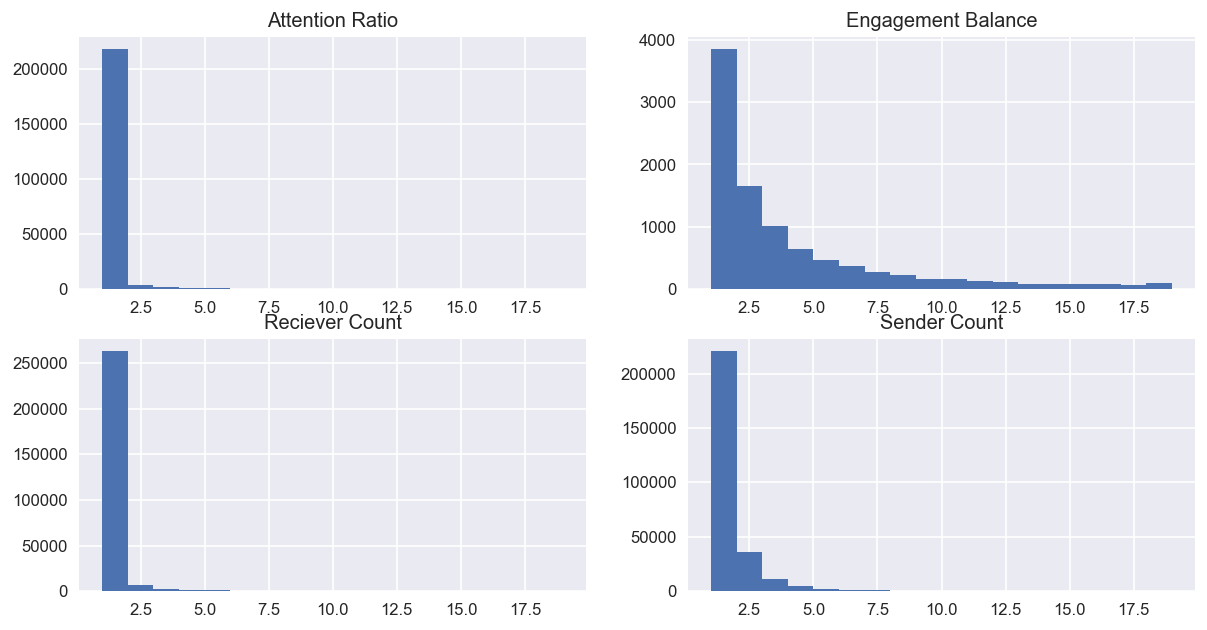

In [61]:
plt.style.use('seaborn-v0_8')

fig, ax = plt.subplots(2, 2, figsize=(12, 6), dpi=120)

ax[0][0].set_title('Attention Ratio')
ax[0][0].hist(df['attention_ratio'], range(1, 20))

ax[0][1].set_title('Engagement Balance')
ax[0][1].hist(df['engagement_balance'], range(1, 20))

ax[1][0].set_title('Reciever Count')
ax[1][0].hist(df['receiver_count'], range(1, 20))

ax[1][1].set_title('Sender Count')
ax[1][1].hist(df['sender_count'], range(1, 20))

fig.show()


##### Insights

1. `Our attention metrics data is very right skewed since 95% of users normally are observers or not influencers nor connector`

2. `The Reciever count is right skewed, who recieve less count is much more`

3. `The Sender count is right skewed, who send less count is much more also`

3. `To train ML models on this data we will need to apply logarithmic transformation on them to achieve better results specially for reciever and sender counts and any feature derived from them`

#### Categorical Features

In [77]:
types_count = df['behavior_label'].value_counts()
types_count

behavior_label
Observer      278768
Connector        601
Promoter           5
Influencer         5
Name: count, dtype: int64

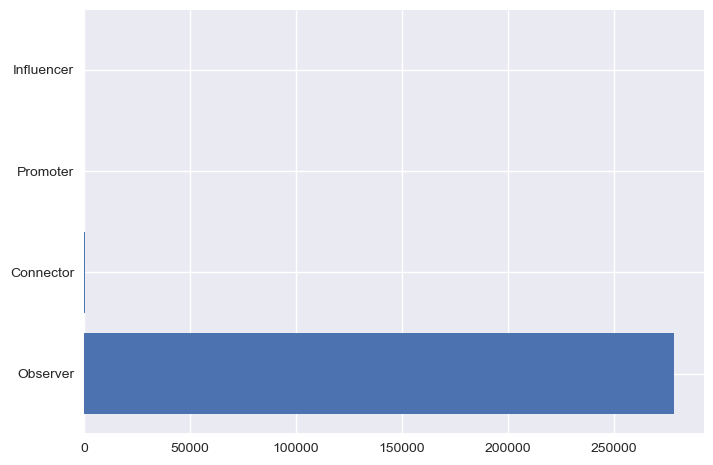

In [80]:
plt.barh(types_count.keys(), types_count.values)
plt.show()

`Note: The behavior label is built using strict rules and conditions for each category not based acurate statistical analysis`

##### Insights

1. `As shown the leading users type is observer , most usere like to only watch and observe`
2. `The next partition are connectors people who are recieving a log`
3. `Promoter are people who sends a lot`
4. `Influencers are people who sends a lot and recieve a lot`

### Apply Log transform on data

In [92]:
logged_engagement_balance = np.log2((df['engagement_balance']))
logged_attention_ratio = np.log2(df['attention_ratio'])
logged_reciever_count = np.log2(df['receiver_count'])
logged_sender_count = np.log2(df['sender_count'])

c:\Users\orobatic\anaconda3\envs\social_profile_analysis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\orobatic\anaconda3\envs\social_profile_analysis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


##### Continuos Features

C:\Users\orobatic\AppData\Local\Temp\ipykernel_22656\787933332.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


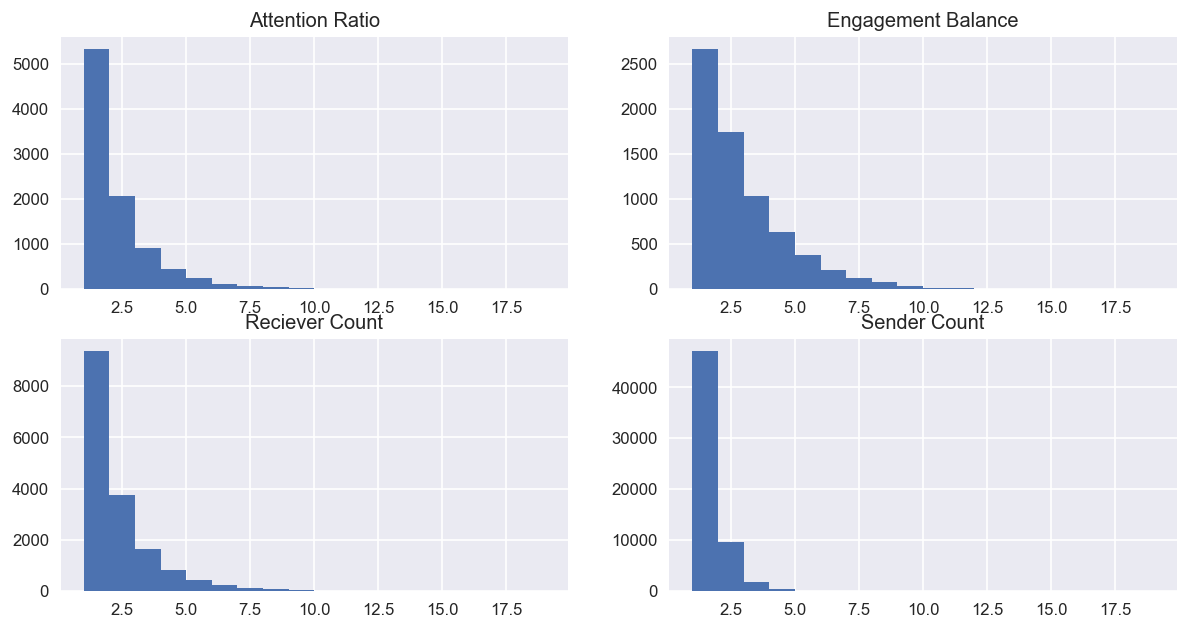

In [93]:
fig2, ax2 = plt.subplots(2, 2, figsize=(12, 6), dpi=120)

ax2[0][0].set_title('Attention Ratio')
ax2[0][0].hist(logged_attention_ratio, range(1, 20))

ax2[0][1].set_title('Engagement Balance')
ax2[0][1].hist(logged_engagement_balance, range(1, 20))

ax2[1][0].set_title('Reciever Count')
ax2[1][0].hist(logged_reciever_count, range(1, 20))

ax2[1][1].set_title('Sender Count')
ax2[1][1].hist(logged_sender_count, range(1, 20))

fig2.show()


##### Categorical Features

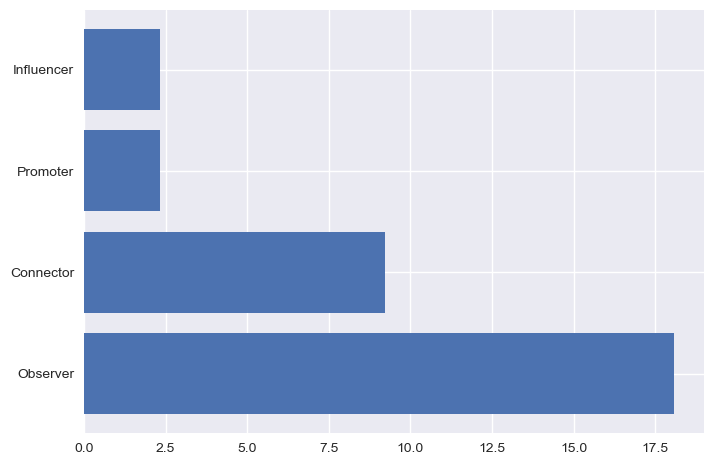

In [94]:
plt.barh(types_count.keys(), np.log2(types_count.values))
plt.show()

### Hypothesis

##### Building Hypothesis

##### Hypothesis Testing